# Classification using Word2Vect model

## Table of Contents

1. [load and cleaning](#data_eda)

    1.1 [load data](#data)
    
    1.2 [Cleaing the text data](#eda)
    
    1.3 [an example text data after cleaning](#example)
    
    1.4 [Dopping Rows with nan](#nan)
    
2. [Vectorization text data](#vectorization)

    2.1  [Vectorization](#vectorization1)
    
    2.2 [display the most frequent words](#mostFreq)

3. [Construct Word2vec Model](#word2vec)

    3.1 [Embedding text data](#embed)
    
    3.2 [Display the nearest words](#w2vExample)

4. [Classification using graphical CNN (ToDo)](#cnn)

In [17]:
%load_ext autoreload
%autoreload 2

import sys, os
from lib import models, graph, coarsening, utils

import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import time, re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='data'></a>
##### Data

In [4]:
data_dir = './data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
train_clean_text_path = os.path.join(data_dir, 'train_clean_text.csv') 

train = utils.TrainDataSet('./data/training_variants', './data/training_text')
test = utils.TestDataSet('./data/test_variants', './data/test_text')

display(train.show_documents())

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


<a id='eda'></a>
##### Clean the text data

In [5]:
# clean text data
train.extract_prof_text()
train.dataset_clean = train.dataset_clean.dropna(how='any', axis=0)
train.text_length(train.dataset_clean)
train.lemmatize(train.dataset_clean)
train.lemmatize(train.dataset_clean, col='Gene')
train_variation_class_pair = train.variation_class()
display(train.dataset_clean.head())
display(train_variation_class_pair.head())

,ID,Gene,Variation,Class,Text,text_prof_tokens,Variation_lemmatized,Gene_lemmatized,text_length
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin kinase cdk cdk1 cdk cyclin kinase cdk1 ...,truncate,fam58a,893
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,nsclc proteomic cbl ubiquitin ligase cbl tyros...,w802,cbl,624
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,nsclc proteomic cbl ubiquitin ligase cbl tyros...,q249e,cbl,624
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,uniparental disomy aupd pathogenetic homozygos...,n454d,cbl,791
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,monomeric casitas cbl cbl cbl missense cbl cbl...,l399v,cbl,616


,Variation_lemmatized,Class
0,truncate,1
1,w802,2
2,q249e,2
3,n454d,3
4,l399v,4


In [6]:
# data clean for test
test.extract_prof_text()
test.dataset_clean = test.dataset_clean.drop(['Text','Gene','Variation'], axis=1)
test_variation= test.dataset_clean[['Variation_lemmatized']]

<a id='example'></a>
##### An example of cleaned text doc

In [16]:
# an example text data after cleaning:
test.dataset_clean['text_prof_tokens'][30][:999]

'stromal gists imatinib sunitinib regorafenib polyclonal exon ponatinib ponatinib imatinib sunitinib regorafenib mutagenesis ponatinib ponatinib ponatinib ponatinib mutagenesis ponatinib v654a ponatinib ponatinib ponatinib keyword ponatinib tyrosine kinase stromal gists tyrosine kinas pdgfra gist exon extracellular ligand juxtamembrane kinase tyrosine kinase tki imatinib r121l fusion secondary atp exon exon imatinib gists mutational imatinib sunitinib atp sunitinib imatinib regorafenib regorafenib centrosome keap1 r121l h1781 r121l r121l ponatinib ap24534 bcr abl pretreat ponatinib bcr abl ponatinib isogenic ponatinib ponatinib dsmz snp cdnas plvx ires puro clontech genscript lentiviral lentiviral orf phospho kit tyr721 erk phospho phospho akt s473 ponatinib ariad imatinib ontariochem sunitinib regorafenib cdna plvx ires puro clontech lentiviral puromycin invitrogen mscf celltiter aqueous promega ic5 xlfit immunoblott lysate supersignal femto mutagenesis nitrosourea kinase molecularmd 

<a id='nan'></a>
##### remove the rows in dataframe with nan

In [8]:
train.text = train.text.dropna(how='any', axis=0)
test.text = test.text.dropna(how='any', axis=0)
# train.text = utils.merge_text_data(train.text, test.text)
# train.text['text_prof_tokens'] = train.text.apply(lambda row: re.sub(r'[00]+', '', row['text_prof_tokens']), axis=1)
# train.text['text_prof_tokens'] = train.text.apply(lambda row: re.sub(r'_+', '', row['text_prof_tokens']), axis=1)
# train.text['text_prof_tokens'] = train.text.apply(lambda row: re.sub(r'aa+', '', row['text_prof_tokens']), axis=1)

<a id='vectorization'></a>

<a id='vectorization1'></a>

## TF vectorizer

In [9]:
train.vectorize_tfidf(train.dataset_clean,max_df=0.3)

<a id='mostFreq'></a>
##### plot the most frequent words

most frequent words
  0: brca1 248.70307861283305 counts
  1: pten 121.3324451268391 counts
  2: egfr 120.45424039613184 counts
  3: brct 94.22019305776655 counts
  4: brca2 72.99125294944974 counts
  5: braf 70.83370747334999 counts
  6: imatinib 68.80701111078659 counts
  7: alk 66.98270962657226 counts
  8: pdgfra 52.921009452252875 counts
  9: p11 50.74539899983619 counts


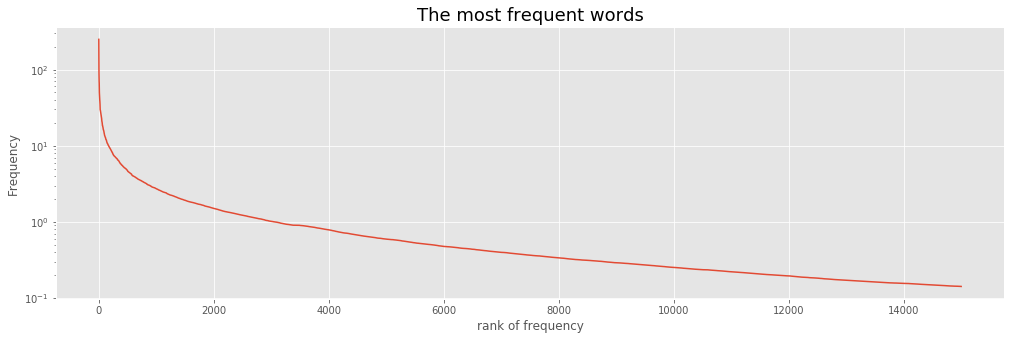

In [22]:
# train.vectorize(train.text)
# print(train.text_vector.shape)
freq = train.keep_top_words(15000, 10)
f= plt.figure(figsize=(17,5))
plt.semilogy(freq)
plt.title('The most frequent words', fontsize=18)
plt.xlabel('rank of frequency')
plt.ylabel('Frequency')
plt.show()

<a id='word2vec'></a>

##  construct word2vec model using skip-gram:

<a id='embed'></a>
##### Embedding using word2vec

In [11]:
train.embed()

287 words not found in corpus


<a id='w2vExample'></a>
##### Example The words near token "n454d"

In [12]:
model = train.model
a =model.wv
a.most_similar('n454d', topn=10)

[('cblc', 0.8124326467514038),
 ('lnk', 0.8061805963516235),
 ('ebpdelta', 0.8019613027572632),
 ('npm1mut', 0.7909771203994751),
 ('npm1wt', 0.7902464866638184),
 ('cblb', 0.7901700735092163),
 ('dnmt3awt', 0.7900798320770264),
 ('dnmt3amut', 0.7813371419906616),
 ('syndromes', 0.769339919090271),
 ('itds', 0.7688202857971191)]

<a id='cnn'></a>

## TODO: Classification using gCNN

In [13]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 16, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 0, 'Number of coarsened graphs.')

flags.DEFINE_string('dir_data', os.path.join('..', 'data', '20news'), 'Directory to store data.')
flags.DEFINE_integer('val_size', 400, 'Size of the validation set.')
graph_data = train.embeddings.astype(np.float64)
graph_data.shape

(15000, 100)

In [14]:
graph_data = train.embeddings.astype(np.float64)
graph_data[np.isnan(graph_data).any(axis=1)]=0
graph_data[(graph_data>1000).any(axis=1)]=0

# np.argmax(np.sum(graph_data, axis=1))
# plt.show()

In [15]:
dist, idx = graph.distance_sklearn_metricsrics(graph_data, k=FLAGS.number_edges, metric=FLAGS.metric)
A = graph.adjacency(dist, idx)
print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
# print('Execution time: {:.2f}s'.format(time.process_time() - t_start))


AttributeError: module 'lib.graph' has no attribute 'distance_sklearn_metricsrics'